# Assignment 2: Spam Classification with SVM

### CS 6316 Machine Learning - Department of Computer Science - University of Virginia
*Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the assignment, you will use SVMs to build your own spam filter. For references, you may refer to my [lecture 6](https://drive.google.com/open?id=1CeBhepjDKBaFBq2BZq-zNQs-MC8ll7aL4qAF8TJ24FM) and [lecture 6b](https://drive.google.com/open?id=13BidUAs_c2QdZkf92axt2S748sbnbI9Hgxg-fzb-OuU) or Chapter 5 of the textbook if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.*


In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import math

# to make this notebook's output stable across runs
np.random.seed(42)

---
## 1. PRE-PROCESSING THE DATA (15 pts)

**Data Acquiring:** Download the dataset from https://archive.ics.uci.edu/ml/datasets/Spambase

**Data Splitting:** Put data into the format needed for SVM, then split it into 80% training, 20% testing (each should have approximately the same proportion of position and negative examples).

**Data Discovery:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. 

**Feature Scaling** You can use the standard Scikit-Learn library can write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

In [1]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from future_encoders import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# DATA ACQUIRING
# setting up file and extracting data from csv
data = pd.read_csv("spambase.data.csv")     # For windows

In [4]:
# DATA SPLITTING
train_set, test_set = train_test_split(data, test_size= 0.2, train_size= 0.8, random_state= 42)
cleaned_train = train_set.drop(["spam_or_not"], axis=1)
cleaned_train.head()
train_pred = train_set["spam_or_not"].copy()
cleaned_test = test_set.drop(["spam_or_not"], axis=1)
test_pred = test_set["spam_or_not"].copy()
corr_matrix = data.corr()

In [5]:
# DATA DISCOVERY
# data.info()
# data.corr()
# corr_matrix["spam_or_not"].sort_values(ascending=False)

In [6]:
# DATA CLEANING
# not applicable, all data is present and of integer type

In [7]:
# FEATURE SCALING
scaler = StandardScaler()
scaled_train = scaler.fit_transform(cleaned_train)
mean = scaler.mean_
variance = scaler.var_
scaled_test = (cleaned_test - mean) / variance

In [8]:
# Finalized Data Sets
X_train = scaled_train;
y_train = train_pred;
X_test = scaled_test;
y_test = test_pred;

- - -
## 2. TRAINING SVM FOR SPAM CLASSIFICATION (15 pts)

Run your linear SVM classifier on the training data, and test the resulting model on the test data. In this section, you may use the default **loss function** (hinge) and **default** value of the C hyperparameter (=1.0):

* Report accuracy, precision, recall?
* Create an ROC curve for this SVM on the test data, using 200 or more evenly spaced thresholds. You may use library function calls to create the ROC curve?

**Implementation Notes:** You do NOT need to add a column of 1's to the $\mathbf{
x}$ matrix to have an intercept term

In [9]:
from sklearn.svm import LinearSVC

# Training your svm here
lin_svm_clf = LinearSVC(C=1, loss="hinge", random_state=42)
lin_svm_clf.fit(X_train, y_train)

# Testing your svm here
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

y_train_pred = lin_svm_clf.predict(X_test)
confusion_matrix(y_test, y_train_pred)

array([[508,  23],
       [ 86, 304]], dtype=int64)

In [10]:
# ACCURACY
accuracy_score(y_test, y_train_pred)

0.8816503800217155

In [11]:
# PRECISION
precision_score(y_test, y_train_pred)

0.9296636085626911

In [12]:
# RECALL
recall_score(y_test, y_train_pred)

0.7794871794871795

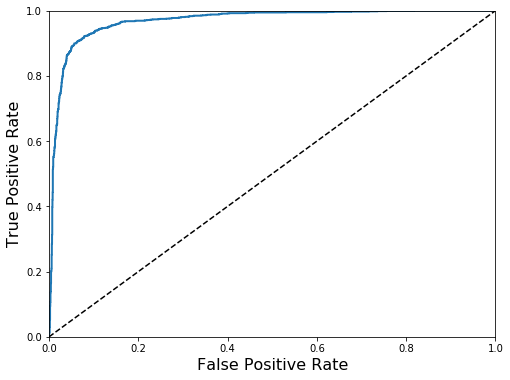

In [13]:
# ROC CURVE using 200 thresholds
y_scores = cross_val_predict(lin_svm_clf, X_train, y_train, cv=3, method="decision_function")

# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
        
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

- - -
## 3. TUNING C FOR LINEAR SVM (15 pts)
In this part of the assignment, you will try using different values of the C parameter with SVMs. Your task is to try different values of C on this dataset. For example, when C is small, you should find that the SVM puts the decision boundary in the gap between the two datasets and misclassifies the data point. When C is large, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data. 

In a 2-D feature space of your choice, you must be able to plot out the decision boundary of SVM for different values of C to earn credit for this section. Depends on your observation on the dataset, you must provide some justifications on the reason you select a certain value of C to tradeoff margin and data violation. 

In [14]:
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [15]:
X = train_set.loc[:,['word_freq_your', 'word_freq_000']]
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

In [16]:
# Finding Optimal C
from sklearn.metrics import f1_score

c_vals = [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 5, 10, 50, 100, 500]

for i in range(len(c_vals)-1):
    svm_clf = LinearSVC(C=c_vals[i], loss="hinge", random_state=42)
    svm_clf.fit(X, y_train)
    y_train_pred = cross_val_predict(svm_clf, scaled_X, y_train, cv=len(c_vals)+1)
    (f1_score(y_train, y_train_pred), c_vals[i])

In [35]:
# Convert to unscaled parameters
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=0.05, loss="hinge", random_state=42) # pick smaller
svm_clf2 = LinearSVC(C=0.01, loss="hinge", random_state=42)
svm_clf3 = LinearSVC(C=0.1, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([ ("scaler", scaler), ("linear_svc", svm_clf1), ])
scaled_svm_clf2 = Pipeline([  ("scaler", scaler),  ("linear_svc", svm_clf2), ])
scaled_svm_clf3 = Pipeline([("scaler", scaler),("linear_svc", svm_clf3), ])

scaled_svm_clf1.fit(scaled_X, y_train)
scaled_svm_clf2.fit(scaled_X, y_train)
scaled_svm_clf3.fit(scaled_X, y_train)

AttributeError: 'LinearSVC' object has no attribute 'shape'

In [18]:
x_max = X_train.max()
x_min = X_train.min()

In [19]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [20]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
b3 = svm_clf3.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
w3 = svm_clf3.coef_[0] / scaler.scale_

svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf3.intercept_ = np.array([b3])

svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])
svm_clf3.coef_ = np.array([w3])

# Find support vectors (LinearSVC does not do this automatically)
t = y_train * 2 - 1
support_vectors_idx1 = (t * (scaled_X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (scaled_X.dot(w2) + b2) < 1).ravel()
support_vectors_idx3 = (t * (scaled_X.dot(w3) + b2) < 1).ravel()

svm_clf1.support_vectors_ = scaled_X[support_vectors_idx1]
svm_clf2.support_vectors_ = scaled_X[support_vectors_idx2]
svm_clf3.support_vectors_ = scaled_X[support_vectors_idx3]

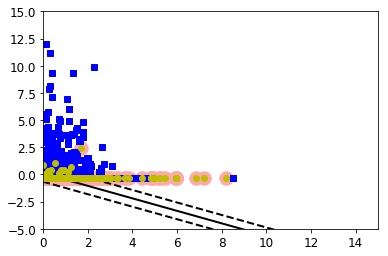

In [21]:
plot_svc_decision_boundary(svm_clf1, x_min, x_max)
plt.plot(scaled_X[:, 0][y_train==1], scaled_X[:, 1][y_train==1], "bs")
plt.plot(scaled_X[:, 0][y_train==0], scaled_X[:, 1][y_train==0], "yo")
plt.axis([0, 15, -5, 15])
plt.show()

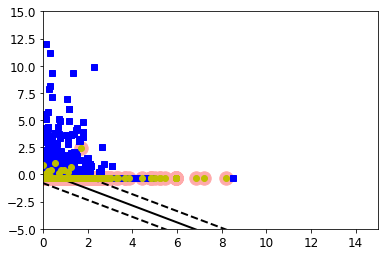

In [22]:
plot_svc_decision_boundary(svm_clf2, x_min, x_max)
plt.plot(scaled_X[:, 0][y_train==1], scaled_X[:, 1][y_train==1], "bs")
plt.plot(scaled_X[:, 0][y_train==0], scaled_X[:, 1][y_train==0], "yo")
plt.axis([0, 15, -5, 15])
plt.show()

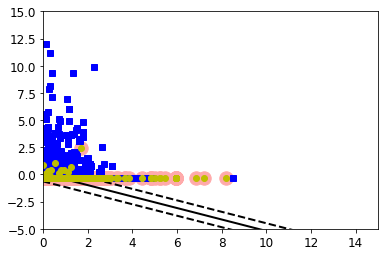

In [23]:
plot_svc_decision_boundary(svm_clf3, x_min, x_max)
plt.plot(scaled_X[:, 0][y_train==1], scaled_X[:, 1][y_train==1], "bs")
plt.plot(scaled_X[:, 0][y_train==0], scaled_X[:, 1][y_train==0], "yo")
plt.axis([0, 15, -5, 15])
plt.show()

- - -
## 4. SELECTING THE FEATURES WITH SVM (25 pts)

Once your learned a best linear SVM in previous sections, your task in this section is to select the best features. First, you must * Obtain the weight vector $\mathbf{w}$. Then, for the number of features $n = 2$ to 57, you will run the following (in a loop of course):

* Select the set of $n$ features that have the highest $\mathbf{w}_n$
* Train an SVM, $SVM_n$, on all training data, only using these $n$ features with the same hyperparameter C.
* Test $SVM_n$ on the test set (using the same $n$ features) to obtain accuracy.
* Plot accuracy on test data vs. $n$ number of features

In one paragraph, discuss the effects of feature selection including the top 5 features.

In [40]:
# Train SVM on Training Data Using Feature Selection
scaler = StandardScaler()
svm_clf = LinearSVC(C=5, loss="hinge", random_state=42)
scaled_svm_clf = Pipeline([ ("scaler", scaler), 
                           ("linear_svc", svm_clf), ])
scaled_svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [41]:
# Obtain weight vector

import operator

w = svm_clf.coef_[0] / scaler.scale_
w = abs(w)
wdict =  dict(zip(train_set.keys(), w))

wkeys, wvalues = zip(*wdict.items())

top_5 = []

# Selecting n features with the highest W
for n in wdict:
    top_5.append((n, wdict[n]))
    
top_5.sort(key=operator.itemgetter(1))
top_5.reverse()
top_5 = top_5[0:5]

newW = {}
for(key, value) in top_5:
    newW[key] = value

#print(top_5)
#print(newW)    

In [42]:
# Test SVM on Test Set
X = train_set.loc[:,['word_freq_make', 'word_freq_all', 'word_freq_our', 'word_freq_address', 'word_freq_3d']]
copy = X.copy()
scaler = StandardScaler()
scaled_X = scaler.fit_transform(copy)


scaler = StandardScaler()
svm_clf = LinearSVC(C=5, loss="hinge", random_state=42)
scaled_svm_clf = Pipeline([ ("scaler", scaler), 
                           ("linear_svc", svm_clf), ])
scaled_svm_clf.fit(copy, y_train)

test = test_set.loc[:,['word_freq_make', 'word_freq_all', 'word_freq_our', 'word_freq_address', 'word_freq_3d']]
y_train_pred = svm_clf.predict(test)
accuracy_score(y_test, y_train_pred)

0.6992399565689468

In [68]:
accuracy = []
n_val = []
for n in range(2, 57):
    X = train_set.loc[:,[wkeys[n]]]
    copy = X.copy()
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(copy)
    
    scaler = StandardScaler()
    svm_clf = LinearSVC(C=5, loss="hinge", random_state=42)
    scaled_svm_clf = Pipeline([ ("scaler", scaler), ("linear_svc", svm_clf), ])
    scaled_svm_clf.fit(copy, y_train)
    test = test_set.loc[:,[wkeys[n]]]
    y_train_pred = svm_clf.predict(test)
    n_val.append(n)
    accuracy.append((accuracy_score(y_test, y_train_pred)* 0.1))


<function matplotlib.pyplot.show(*args, **kw)>

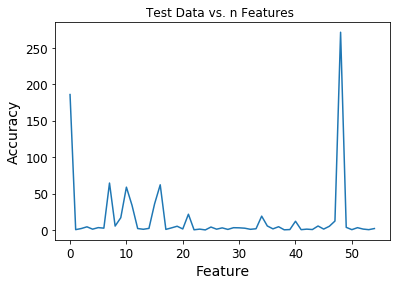

In [67]:
# Plot Accuracy v. # Features
plt.plot(accuracy)
plt.xlabel('Feature')
plt.ylabel('Accuracy')
plt.title('Test Data vs. n Features ')
# plt.axis([0, 55, 0, 1])
plt.show

In [ ]:
# Paragraph

# Reducing the number of features that the test set used reduced the overall accuracy. I think this is primarily
# because reducing the overall numberof features that are used to train a model reduces its ability to appropriately 
# scale to when testing, as it has less information to generalize from, and thus explains the overall reduction in 
# accuracy when using the values with only the highest correlations in the spam set.

- - -
## 5. KERNELIZING SVM WITH THE GAUSSIAN RBF (30 pts)

In this part of the assignment, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable. 

$
    \mathbf{K}_{RBF}(\mathbf{x}^{(i)},\mathbf{x}^{(j)}) = \exp(-\gamma ||\mathbf{x}^{(i)} -\mathbf{x}^{(j)}||^2).
$

Your task is to determine the best $C$ and $\gamma$ hyperparameters to use, run SVM on the spam data and report the performance in metrics similar to section 2. By using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for this dataset. 

Finally, run the version of SVM with the best hyperparameters on the test set, and plot out the comparison in terms of accuracy, precision, and recall, and the ROC curve) to those of linear SVM in Section 3. How much your SVM classifier perform better? 

**Implementation Note:** When implementing cross validation to select the best C and $\gamma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly.




In [138]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [155]:
# Determine the best  C  and  γ  hyperparameters to use
params = {'gamma': [0.001, 0.01, 0.1, 1],
                     'C':[ 0.01, 0.1, 1, 10, 1000]}

grid_search = GridSearchCV(SVC(), params, cv=5)
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'C': 1000, 'gamma': 0.001}

In [156]:
# Run SVM (RBF)
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=0.001, C=1000))
    ])
rbf_kernel_svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [157]:
# Run on Test Set
y_train_pred = rbf_kernel_svm_clf.predict(X_test)
confusion_matrix(y_test, y_train_pred)

array([[525,   6],
       [159, 231]], dtype=int64)

In [158]:
# ACCURACY
accuracy_score(y_test, y_train_pred)

0.8208469055374593

In [159]:
# PRECISION
precision_score(y_test, y_train_pred)

0.9746835443037974

In [160]:
# RECALL
recall_score(y_test, y_train_pred)

0.5923076923076923

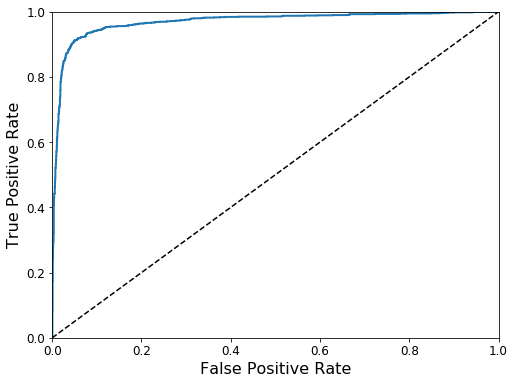

In [161]:
# ROC CURVE using 200 thresholds
y_scores = cross_val_predict(rbf_kernel_svm_clf, X_train, y_train, cv=3, method="decision_function")

# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]
        
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# Comments
# It was interesting to see that the overall accuracy and recall scores worsened when using the RBF model
# interestingly enough, however, the precision remained about the same.  Linear models tend to perform
# very well and generally do not require as many resources to train with without a reduction predictive performance.

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 6](https://drive.google.com/open?id=1CeBhepjDKBaFBq2BZq-zNQs-MC8ll7aL4qAF8TJ24FM) and [lecture 6b](https://drive.google.com/open?id=13BidUAs_c2QdZkf92axt2S748sbnbI9Hgxg-fzb-OuU) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](https://docs.google.com/document/d/15qB84xjaS-uRJmfKmmQuCz38bLMFaoqdbuRLoZEdOYI/edit#heading=h.72k1pvft525n)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS6316 Assignment 2:...".

Best of luck and have fun!